In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset

In [72]:
IMG_SIZE = 128
LATENT_DIM = 4096
EPOCHS = 50
LR = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Crop center to remove background
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [74]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

In [75]:
torch.manual_seed(42)
indices = torch.randperm(162770)[:80000] # 80k subset of training image indices

dataset = datasets.ImageFolder(root=path, transform=transform)
dataset = Subset(dataset, indices)  # Create subset of dataset

In [ ]:
# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(512, 1024, 4, 2, 1), nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(1024 * 4 * 4, LATENT_DIM)
        self.fc_logvar = nn.Linear(1024 * 4 * 4, LATENT_DIM)
        
        # Decoder
        self.fc_decode = nn.Linear(LATENT_DIM, 1024 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        x_recon = self.decoder(self.fc_decode(z).view(z.size(0), 1024, 4, 4))
        return x_recon
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

In [81]:
from tqdm import tqdm

def train_vae(vae_model, epochs=5, learning_rate=1e-3, batch_size=32):
    vae_model.to(device)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)
    
    vae_model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, _ in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()
            recon_images, mu, logvar = vae_model(images)
            loss = vae_loss_function(recon_images, images, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=total_loss/len(dataloader.dataset))

        if epoch % 5 == 0:
            torch.save(vae_model.state_dict(), "vae_celebA.pth")

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader.dataset):.4f}")

In [82]:
vae = VAE()

In [84]:
# train_vae(vae, batch_size=64, epochs=50)
vae.load_state_dict(torch.load('vae_celebA.pth'))

<All keys matched successfully>

In [85]:
import numpy as np
from sklearn.decomposition import PCA

def get_latent_vectors(dataset):
    vae.to(device)
    vae.eval()
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    latent_vectors = []
    total_samples = len(dataset)  # Total number of images

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Extracting Latent Vectors", unit="batch")
        for images, _ in progress_bar:
            images = images.to(device)
            z, _, _ = vae.encode(images)
            latent_vectors.append(z.cpu().numpy())
            
            # Update progress description
            progress_bar.set_postfix(processed=len(latent_vectors) * dataloader.batch_size, total=total_samples)

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    return latent_vectors

def get_pca_components(data, n_components=5):
    pca = PCA(n_components)
    pca.fit(data)
    return pca.components_

def get_z_pair(principal_vec, n=5, epsilon=2.0):
    z_pairs = []

    principal_vec = torch.tensor(principal_vec, dtype=torch.float32, device=device)

    for _ in range(n):
        z = torch.randn(1, LATENT_DIM, device=device)
        z_modified = z + epsilon * principal_vec

        z_pairs.append((z, z_modified))

    z_originals, z_modifieds = zip(*z_pairs)
    return torch.stack(z_originals), torch.stack(z_modifieds)

In [357]:
latent_vectors = get_latent_vectors(dataset)
principal_components = get_pca_components(latent_vectors, n_components=15)
print("PCA fit done")

Extracting Latent Vectors: 100%|██████████| 2500/2500 [03:23<00:00, 12.26batch/s, processed=8e+4, total=8e+4] 


PCA fit done


In [358]:
len(principal_components)

15

In [509]:
import matplotlib.pyplot as plt

def plot_image_pairs(img_original, img_modified, title="Original vs Modified"):
    assert len(img_original) == len(img_modified), "Both lists must have the same length!"
    
    num_images = len(img_original)
    fig, axes = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))
    fig.suptitle(title, fontsize=16)
    
    if num_images == 1:
        axes = [axes]
    
    for i in range(num_images):
        original = img_original[i].cpu().detach().numpy().transpose(1, 2, 0)
        modified = img_modified[i].cpu().detach().numpy().transpose(1, 2, 0)
        
        axes[i][0].imshow(original)
        axes[i][0].set_title("Original")
        axes[i][0].axis("off")
        
        axes[i][1].imshow(modified)
        axes[i][1].set_title("Modified")
        axes[i][1].axis("off")
    
    plt.tight_layout()
    plt.show()

In [718]:
prin_comp_idx = 2
assert(prin_comp_idx < len(principal_components))
z, z_modified = get_z_pair(principal_components[prin_comp_idx], epsilon=7.0, n=1)

In [719]:
with torch.no_grad():
    vae.eval()
    img_original = vae.decode(z).cpu().detach()
    img_modified = vae.decode(z_modified).cpu().detach()

# Scale from [-1, 1] → [0, 1]
img_original = (img_original + 1) / 2
img_modified = (img_modified + 1) / 2

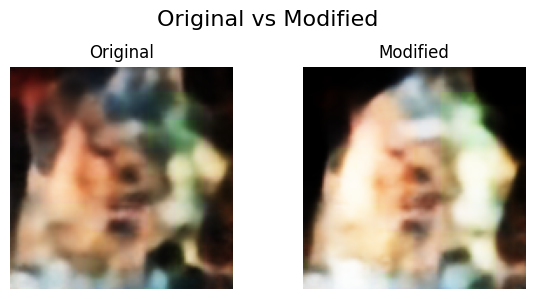

In [720]:
plot_image_pairs(img_original, img_modified)